# Exploring convex optimization

With CVXPY.

In [20]:
import cvxpy as cp
import numpy as np

from pprint import pprint

---

Trivial linear program example.

In [19]:
x, y = cp.Variable(), cp.Variable()

constraints = [
    x >= 1,
    y <= -1,
]

objective = cp.Minimize((x - y) ** 2)

problem = cp.Problem(objective, constraints)
problem.solve()

pprint({
    'status': problem.status,
    'value':  problem.value,
    'x': x.value,
    'y': y.value,
})

{'status': 'optimal', 'value': 4.0, 'x': array(1.), 'y': array(-1.)}


---

Optimal transport linear program.

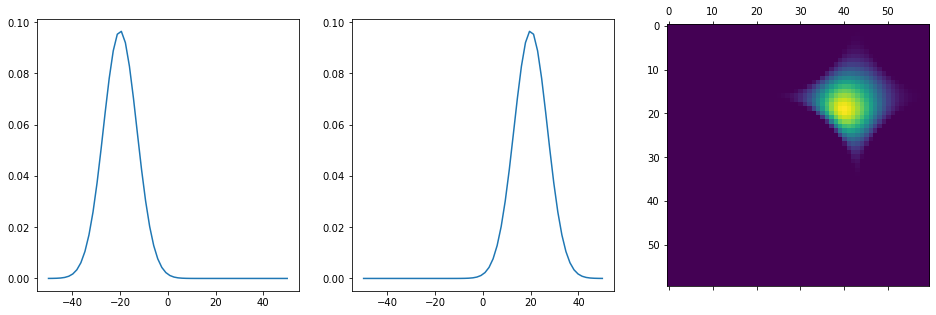

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


n, m = 60, 60
x = np.linspace(-50, 50, n)
y = np.linspace(-50, 50, m)

u = norm.pdf(x, loc=-20, scale=7)
u /= u.sum()
v = norm.pdf(y, loc=20, scale=7)
v /= v.sum()

C = np.abs(np.subtract.outer(x, y))

pi = cp.Variable((n, m))

constraints = [
    cp.sum(pi, axis=1) == u,
    cp.sum(pi, axis=0) == v,
    pi >= 0
]

objective = cp.Minimize(cp.sum_squares(cp.multiply(pi, C)))

problem = cp.Problem(objective, constraints)
problem.solve()

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(16, 5))
a1.plot(x, u)
a2.plot(y, v)
a3.matshow(pi.value)